In [1]:
import os
import sys

# add the 'src' directory as one where we can import modules
# os.pardir refers to parent directory. 
# src_dir = os.path.join(os.getcwd(), '../src') => works the same
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 2


In [2]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from features import preprocessor
import gzip

from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize


In [3]:
def load_corpus(data_file, label_index, text_index):
    target= []
    data = []

    with gzip.open(data_file, 'r') as f:
        for line in f:
            line_arr = line.decode('utf8').split('\t')
            data.append(line_arr[text_index])
            target.append(line_arr[label_index])
    f.close()

    return [data, target]

def doc2vec(text, stop_words, vectorizer):
    pp_text = preprocessor.process_data(text, stop_words)
    return vectorizer.transform(list(text))

def create_output(labels, topics, data, file_dir):
    combined = zip(labels, topics, data)
    combined = sorted(combined, key=lambda k: k[0])
    with open(file_dir, 'w') as f:
        for label, topic, text in combined:
            f.write(str(label) + '\t' + str(topic) + '\t' + text + '\n')
    f.close()

def top_words(data, num):
    words = []
    for row in data:
        words += word_tokenize(row[1][0])
    fdist= FreqDist(words)
    return fdist.most_common(num)

# cluster_top_words is a list of list of topwords from each cluster
def unique_words(cluster_top_words):
    common_words = []
    unique_words = []
    all_words = []
    for top_words in cluster_top_words:
        words = [word[0] for word in top_words]
        # if words not in common wrds 
        all_words += words

def cluster_top_words(clusters, top_num):
    cluster_list = [clusters[key] for key in clusters.keys()]
    top_words_list = []
    for cluster in cluster_list:
        top_words_list.append(top_words(cluster, top_num))
    
    common_words = []
    for words in top_words_list:
        words = [word[0] for word in words]
        for word in words:
            common = True
            for words_1 in top_words_list:
                words_1 = [word_1[0] for word_1 in words_1]
                if word not in words_1:
                    common = False
                    break
            if common:
                common_words.append(word)
    toReturn = []
    for words in top_words_list:
        words = [word[0] for word in words if word[0] not in common_words]
        toReturn.append(words)
    print (toReturn)
    return toReturn
    
def create_topwords(tw_list, file_dir):
    with open(file_dir, 'w') as f:
        for row in tw_list:
            f.write(str(row) + '\n')
    f.close
        

In [196]:
# load data
data, target = load_corpus('../data/train/NDR2016_president.tsv.gz', 1, 2)

# preprocess data
stop_words = stopwords.words('english')
stop_words += ['would', 'said', 'say', 'year', 'day', 'also', 'first', 'last', 'one', 'two', 'people', 'told', 'new',
    'could', 'singapore', 'three', 'may', 'like', 'world', 'since','mr','time','even','make','many','take','still','well',
    'get','want','made','go','much','dr']

pp_data = [preprocessor.process_data(row, stop_words) for row in data]



In [197]:
# convert to term frequency
data_tf_vector = CountVectorizer().fit_transform(pp_data)

data_tfidf_vector = TfidfVectorizer().fit_transform(pp_data)

In [304]:
# fit model
kmeans = KMeans(n_clusters=10).fit(data_tfidf_vector)


In [305]:
kmeans.cluster_centers_.shape

(10, 4535)

In [306]:
data_tfidf_vector.shape

(916, 4535)

In [307]:
labels = list(kmeans.labels_)

In [308]:
cluster_dict = {}
for label, topic, text in zip(labels, target, pp_data):
    if label not in cluster_dict:
        cluster_dict[label] = []
    cluster_dict[label].append([[topic],[text]])

cluster_dict.keys()

dict_keys([1, 3, 5, 0, 8, 7, 2, 9, 4, 6])

In [309]:
topwords = cluster_top_words(cluster_dict, 10)

[['president', 'elected', 'minority', 'race', 'pap', 'malay', 'chinese', 'candidate', 'election', 'vote'], ['tan', 'president', 'million', 'company', 'election', 'candidate', 'year', 'presidential', 'position', 'cheng'], ['president', 'next', 'pe', 'mean', 'must', 'think', 'criterion', 'mute', 'approved', 'yrs'], ['president', 'minority', 'know', 'next', 'talking', 'race', 'token', 'care', 'think', 'chinese'], ['elected', 'presidency', 'pap', 'job', 'created', 'intention', 'president', 'issue', 'miw', 'minister'], ['president', 'wp', 'prefer', 'elected', 'need', 'bad', 'point', 'appointed', 'increasing', 'change'], ['president', 'bill', 'criterion', 'approve', 'lee', 'elected', 'using', 'allow', 'got', 'mouth'], ['president', 'claim', 'race', 'tcb', 'pe', 'become', 'let', 'malay', 'indian', 'ask'], ['govt', 'president', 'otc', 'role', 'causing', 'pinoy', 'ep', 'pe', 'problem', 'insulting'], ['skeleton', 'closet', 'make', 'wonder', 'pap', 'afraid', 'someone', 'outside', 'party', 'becomi

In [310]:
create_output(labels, target, pp_data, '../data/results/cluster_of_10_1.txt')

In [311]:
create_topwords(topwords, '../data/results/topwords_of_10_1.txt')

In [206]:
# 10 clusters
cluster_top_words(cluster_dict, 10)

['elected', 'president', 'election', 'waste', 'mouth', 'kick', 'wee', 'pap', 'pinky', 'open']
['president', 'minority', 'elected', 'race', 'pap', 'ep', 'power', 'next', 'election', 'reserve']
['president', 'malay', 'chinese', 'vote', 'candidate', 'minority', 'elected', 'using', 'sent', 'non']
['president', 'criterion', 'tan', 'lee', 'candidate', 'must', 'qualify', 'using', 'cheng', 'bock']
['president', 'job', 'role', 'govt', 'otc', 'need', 'elected', 'change', 'wp', 'head']
['tan', 'million', 'company', 'year', 'position', 'executive', 'equity', 'senior', 'candidate', 'shareholder']
['tcb', 'president', 'pe', 'claim', 'become', 'know', 'race', 'need', 'dont', 'review']
['party', 'afraid', 'president', 'skeleton', 'closet', 'make', 'wonder', 'pap', 'someone', 'outside']
['elected', 'presidency', 'pap', 'intention', 'issue', 'created', 'bad', 'sign', 'minority', 'presidencycan']
['pinoy', 'president', 'next', 'given', 'collective', 'intellect', 'cooly', 'prata', 'flipper', 'pirate']


In [181]:
# 7 clusters
cluster_top_words(cluster_dict, 10)

['elected', 'minority', 'race', 'pap', 'candidate', 'ep', 'election', 'presidency', 'need']
['tan', 'million', 'criterion', 'company', 'year', 'candidate', 'election', 'bock', 'position']
['malay', 'chinese', 'using', 'vote', 'minority', 'pinoy', 'sent', 'indian', 'next']
['waste', 'money', 'election', 'resource', 'point', 'whole', 'choice', 'need', 'guy']
['elected', 'bad', 'wp', 'issue', 'pap', 'presidency', 'need', 'job', 'prefer']
['tcb', 'govt', 'pe', 'otc', 'claim', 'role', 'know', 'become', 'job']
['party', 'wonder', 'afraid', 'skeleton', 'closet', 'make', 'pap', 'someone', 'outside']


In [174]:
# 6 clusters
cluster_top_words(cluster_dict, 10)

['elected', 'pap', 'presidency', 'power', 'reserve', 'ep', 'vote', 'election', 'party']
['minority', 'race', 'malay', 'chinese', 'elected', 'candidate', 'next', 'pap', 'need']
['tan', 'criterion', 'million', 'candidate', 'election', 'company', 'bock', 'year', 'cheng']
['pinoy', 'next', 'election', 'pe', 'waste', 'given', 'collective', 'intellect', 'cooly']
['role', 'job', 'elected', 'need', 'otc', 'govt', 'head', 'state', 'bad']
['tcb', 'pe', 'claim', 'become', 'ep', 'need', 'know', 'race', 'bill']


In [167]:
# 5 clusters
cluster_top_words(cluster_dict, 10)

['tan', 'elected', 'presidency', 'million', 'election', 'presidential', 'company', 'minority', 'candidate']
['elected', 'minority', 'race', 'pap', 'malay', 'candidate', 'ep', 'vote', 'next']
['pe', 'tcb', 'need', 'race', 'become', 'claim', 'let', 'money', 'tan']
['govt', 'role', 'otc', 'job', 'change', 'elected', 'need', 'wp', 'head']
['someone', 'party', 'afraid', 'wonder', 'skeleton', 'pap', 'closet', 'make', 'outside']


In [244]:
# 4 clusters
cluster_top_words(cluster_dict, 10)

[['elected',
  'minority',
  'race',
  'pap',
  'malay',
  'candidate',
  'chinese',
  'next',
  'tcb'],
 ['tan',
  'million',
  'elected',
  'criterion',
  'candidate',
  'election',
  'company',
  'year',
  'bock'],
 ['elected', 'govt', 'job', 'wp', 'need', 'role', 'otc', 'pap', 'reserve'],
 ['pinoy',
  'next',
  'must',
  'pe',
  'party',
  'skeleton',
  'closet',
  'make',
  'wonder']]

In [188]:
# 3 clusters
cluster_top_words(cluster_dict, 10)

['elected', 'minority', 'race', 'pap', 'tan', 'candidate', 'election', 'malay', 'presidency']
['pe', 'tcb', 'tan', 'criterion', 'next', 'become', 'lol', 'claim', 'race']
['govt', 'elected', 'need', 'wp', 'role', 'otc', 'job', 'point', 'change']


In [2]:
# create clusters from data
%run ../src/models/objectivity_cluster.py --data ../data/train/NDR2016_president_set.tsv.gz --label_index 0 --text_index 1 --cluster kmeans --c_out ../data/results/cluster_of_4_3.txt --tw_out ../data/results/topwords_of_4_3.txt --num_clusters 4 --num_tw 10



In [12]:
# find out prob distribution of topic for each document and get entropy
%run ../src/models/objectivity_classification.py --data ../data/results/cluster_of_4_3.txt --label_index 0 --pos_index 1 --text_index 2 --model lr --output ../data/results/ent_probdist_of_4_3.txt


median: 0.3479468825545


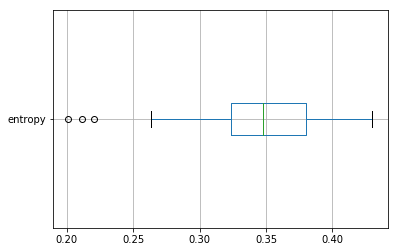

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

headers = ['entropy','prob', 'pos', 'text']
df = pd.read_csv('../data/results/final_cluster_5.txt', sep='\t', names=headers)
df.boxplot(column='entropy', vert=False)
print ('median: ' + str(df['entropy'].median()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11979d6a0>]], dtype=object)

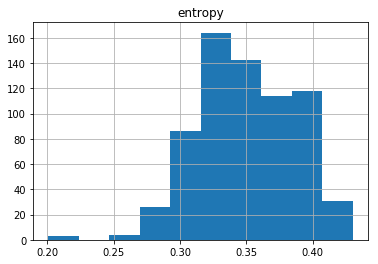

In [14]:
df.hist(column='entropy',bins=10)

median: 0.132363188219


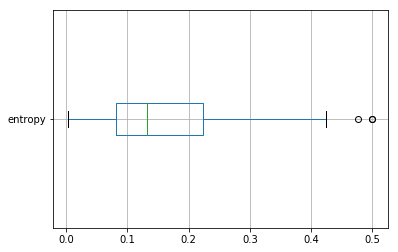

In [9]:
df = pd.read_csv('../data/results/lda_4.txt', sep='\t', names=headers)
df.boxplot(column='entropy', vert=False)
print ('median: ' + str(df['entropy'].median()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117c94048>]], dtype=object)

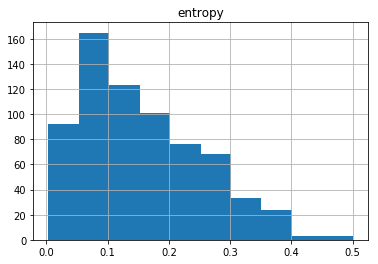

In [10]:
df.hist(column='entropy',bins=10)

In [ ]:
%matplotlib inline
data_tfidf_vector.sc

In [22]:
# remove duplicates
import gzip
def load_corpus(data_file, text_index, source_index):
    data = []
    sources = []
    with gzip.open(data_file, 'r') as f:
        for line in f:
            line_arr = line.decode('utf8').split('\t')
            data.append(line_arr[text_index])
            sources.append(line_arr[source_index])
    f.close()
    return [data, sources]

data, sources = load_corpus('../data/train/NDR2016_president.tsv.gz', 2, 0)
print("all rows: " + str(len(data)))

data_map = dict()


for row, source in zip(data, sources):
    if row not in data_map.keys():
        data_map[row] = source

source_map = dict()
for key in data_map.keys():
    source = data_map[key]
    if source not in source_map.keys():
        source_map[source] = 0
    source_map[source] = source_map[source] + 1

print(source_map)

ndata = list(data_map.keys())
print("non-repeated rows: " + str(len(ndata)))


with open('../data/train/NDR2016_president_set.tsv', 'w') as f:
    for i in range(len(ndata)):
        f.write(str(i) + '\t' + ndata[i])
f.close()

all rows: 916
{'mothership': 4, 'statestimesreview': 21, 'themiddleground': 2, 'allsingaporestuff': 2, 'asiaone': 30, 'hardwarezone': 389, 'sammyboy': 61, 'today': 13, 'reddit': 17, 'twitter': 2, '5082430588': 8, '5128547268': 1, '5121868643': 6, '5127789698': 8, '5105804987': 26, '5120453382': 4, '5084114749': 6, '5124040220': 4, '5124540006': 2, '5093090631': 4, '5090149007': 7, '5083363203': 1, '5127488433': 15, '5130194219': 5, '5117976663': 2, '5085433961': 2, '5120237953': 21, '5083077230': 11, '5075136108': 1, '5133691140': 7, '5084350361': 1, '5048696420': 5}
non-repeated rows: 688


In [45]:
import numpy as np
# calculate rank correlation
def get_ranks(file_dir, pos_index):
    pos = []
    rank = []
    i = 1
    with open(file_dir, 'r') as f:
        for line in f:
            line = line.split('\t')
            pos.append(int(line[pos_index]))
            rank.append(i)
            i += 1
    f.close()
    
    combined = zip(pos, rank)
    combined = sorted(combined, key=lambda k: k[0])
    
    return combined

# both list must be same length
# for n unique ranks
def get_sc(list1, list2):
    n = len(list1)
    sum_d_sqr = 0
    for a, b in zip(list1, list2):
        d = (a[1] - b[1])
        d_sqr = d*d
        sum_d_sqr += d_sqr
    result = 1 - (6*sum_d_sqr)/((n)*(n*n - 1))
    return result

# for fixed range of ranks. E.g. 1-5
def get_sc2(list1, list2):
    n = len(list1)
    x_scores = []
    y_scores = []
    for a, b in zip(list1, list2):
        x_scores.append(a[1])
        y_scores.append(b[1])
    x_scores = np.array(x_scores)
    y_scores = np.array(y_scores)
    cov = np.cov(x_scores, y_scores)[0][1]
    x_sd = np.std(x_scores, dtype=np.float64)
    y_sd = np.std(y_scores, dtype=np.float64)
    print(cov)
    return cov / (x_sd * y_sd)

    

In [46]:
lda_pos_rank = get_ranks('../data/results/lda_4_3.txt', 2)
cluster_pos_rank = get_ranks('../data/results/ent_probdist_of_4_1.txt', 2)
get_sc(lda_pos_rank, cluster_pos_rank)


0.09854032296458015

In [48]:
cluster_pos_rank = get_ranks('../data/results/ent_probdist_of_4_1.txt', 2)
cluster_pos_rank2 = get_ranks('../data/results/ent_probdist_of_4_3.txt', 2)
get_sc(cluster_pos_rank, cluster_pos_rank2)

-0.1661376609291978

In [54]:
# get the list of position numbers and score
manual_score = []
manual_pos = []

with open('../data/train/objectivity_manual_sample.tsv', 'r') as f:
    for line in f:
        line = line.split('\t')
#         print(line)
        manual_score.append(int(line[0]))
        manual_pos.append(int(line[1]))
f.close()

# get the 1-5 score for cluster results
cluster_score = []
cluster_pos = []
score = 0
size = len(cluster_pos_rank)

for i in range(len(cluster_pos_rank)):
    if i % (round(size/5)) == 0:
        score += 1
    if score == 6:
        score = 5
    pos = int(cluster_pos_rank[i][0])
    if pos in manual_pos:
        cluster_pos.append(pos)
        cluster_score.append(score)

manual_combined = zip(manual_pos, manual_score)
manual_combined = sorted(manual_combined, key=lambda k: k[0])
cluster_combined = zip(cluster_pos, cluster_score)
cluster_combined = sorted(cluster_combined, key=lambda k: k[0])
get_sc2(manual_combined,cluster_combined)

0.315789473684


0.14486365330610007

In [50]:
# get the 1-5 score for cluster results
lda_score = []
lda_pos = []
score = 0
size = len(lda_pos_rank)

for i in range(len(lda_pos_rank)):
    if i % (round(size/5)) == 0:
        score += 1
    if score == 6:
        score = 5
    pos = int(lda_pos_rank[i][0])
    if pos in manual_pos:
        lda_pos.append(pos)
        lda_score.append(score)

lda_combined = zip(cluster_pos, cluster_score)
lda_combined = sorted(cluster_combined, key=lambda k: k[0])
get_sc2(manual_combined,lda_combined)

0.315789473684


0.14486365330610007

In [30]:
manual_combined

[(13, 1),
 (22, 3),
 (57, 3),
 (60, 5),
 (85, 2),
 (156, 5),
 (161, 2),
 (192, 4),
 (269, 3),
 (307, 1),
 (328, 1),
 (335, 2),
 (340, 1),
 (370, 4),
 (385, 5),
 (577, 5),
 (618, 4),
 (619, 2),
 (637, 2),
 (681, 5)]

In [31]:
cluster_combined


[(13, 1),
 (22, 1),
 (57, 1),
 (60, 1),
 (85, 1),
 (156, 2),
 (161, 2),
 (192, 2),
 (269, 2),
 (307, 3),
 (328, 3),
 (335, 3),
 (340, 3),
 (370, 3),
 (385, 3),
 (577, 5),
 (618, 5),
 (619, 5),
 (637, 5),
 (681, 5)]

In [32]:
cluster_pos_rank

[(0, 688),
 (1, 627),
 (2, 343),
 (3, 209),
 (4, 68),
 (5, 635),
 (6, 658),
 (7, 268),
 (8, 305),
 (9, 439),
 (10, 481),
 (11, 42),
 (12, 348),
 (13, 523),
 (14, 345),
 (15, 423),
 (16, 647),
 (17, 657),
 (18, 520),
 (19, 98),
 (20, 579),
 (21, 288),
 (22, 653),
 (23, 221),
 (24, 130),
 (25, 107),
 (26, 356),
 (27, 138),
 (28, 626),
 (29, 562),
 (30, 3),
 (31, 437),
 (32, 23),
 (33, 402),
 (34, 72),
 (35, 77),
 (36, 438),
 (37, 303),
 (38, 530),
 (39, 11),
 (40, 110),
 (41, 135),
 (42, 390),
 (43, 590),
 (44, 325),
 (45, 540),
 (46, 400),
 (47, 409),
 (48, 441),
 (49, 502),
 (50, 560),
 (51, 309),
 (52, 322),
 (53, 333),
 (54, 397),
 (55, 226),
 (56, 624),
 (57, 193),
 (58, 144),
 (59, 65),
 (60, 163),
 (61, 340),
 (62, 598),
 (63, 224),
 (64, 652),
 (65, 457),
 (66, 350),
 (67, 408),
 (68, 473),
 (69, 546),
 (70, 111),
 (71, 222),
 (72, 430),
 (73, 109),
 (74, 571),
 (75, 315),
 (76, 501),
 (77, 519),
 (78, 22),
 (79, 210),
 (80, 247),
 (81, 53),
 (82, 143),
 (83, 202),
 (84, 323),
 (

# Obtain all posts related to ['elected presidency','eligibility criteria','minority representation'] from each data source

In [ ]:
%run ../src/models/objectivity_train.py --data ../data/train/NDR2016_president.tsv.gz --predict True --num_topics 5 --threshold 80 --topics ../data/results/president_topics3.txt --output ../data/results/president_labels_3.txt  